In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

resultPath = "resultFiles/featureExtractionV3_by_Jun/"
x = 'CD4'
#df_healthy = pd.read_csv(resultPath+"HealthyPatients/"+x+".Ranksum.RFECV.act.csv", index_col=0)
df_long = pd.read_csv(resultPath+"LongDiseaseDuration/"+x+".Ranksum.RFECV.act.csv", index_col=0)

#intersected_act = list(set(df_healthy.index.tolist()).intersection(df_long.index.tolist()))
#len(intersected_act)

In [2]:
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit
import itertools
def _LoadDiseaseDuration(df, meta_data, returntype='long'):
    """
    df : Expression or activation score matrix
    meta_data : meta data which contains duration and sample ID
    output: long DD samples and short DD samples by list, or healthy samples and short DD samples by list
    """
    # Sample by disease category
    sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
    
    # Sort by disease category and exclude uknown samples
    patient_samples = [] # patient samples
    healthy_samples = [] # healthy samples
    for samples, category in zip(sample_list, sample_category):
        if category=='Healthy':
            healthy_samples = samples
        else:
            if category!='Unknown':# Excluding unknown samples
                patient_samples.append(samples)

    patient_samples = list(itertools.chain(*patient_samples)) # flatten
    patient_samples = list(set(patient_samples).intersection(df.columns.tolist())) # intersected with act score matrix
    healthy_samples = list(set(healthy_samples).intersection(df.columns.tolist())) # intersected with act score matrix
    patient_meta = meta_data.loc[meta_data['HCVB_ID'].isin(patient_samples)] # Make patient metadata

    longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(patient_meta, 'HCVB_ID', 'DiseaseDuration', 25)
    longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
    shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix

    if returntype=='long':
        return longDD_samples, shortDD_samples
    elif returntype=='healthy':
        return healthy_samples, shortDD_samples

In [3]:
meta_data = pd.read_csv('../data/annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')
longDD_samples, shortDD_samples = _LoadDiseaseDuration(df_long, meta_data, 'long')

/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


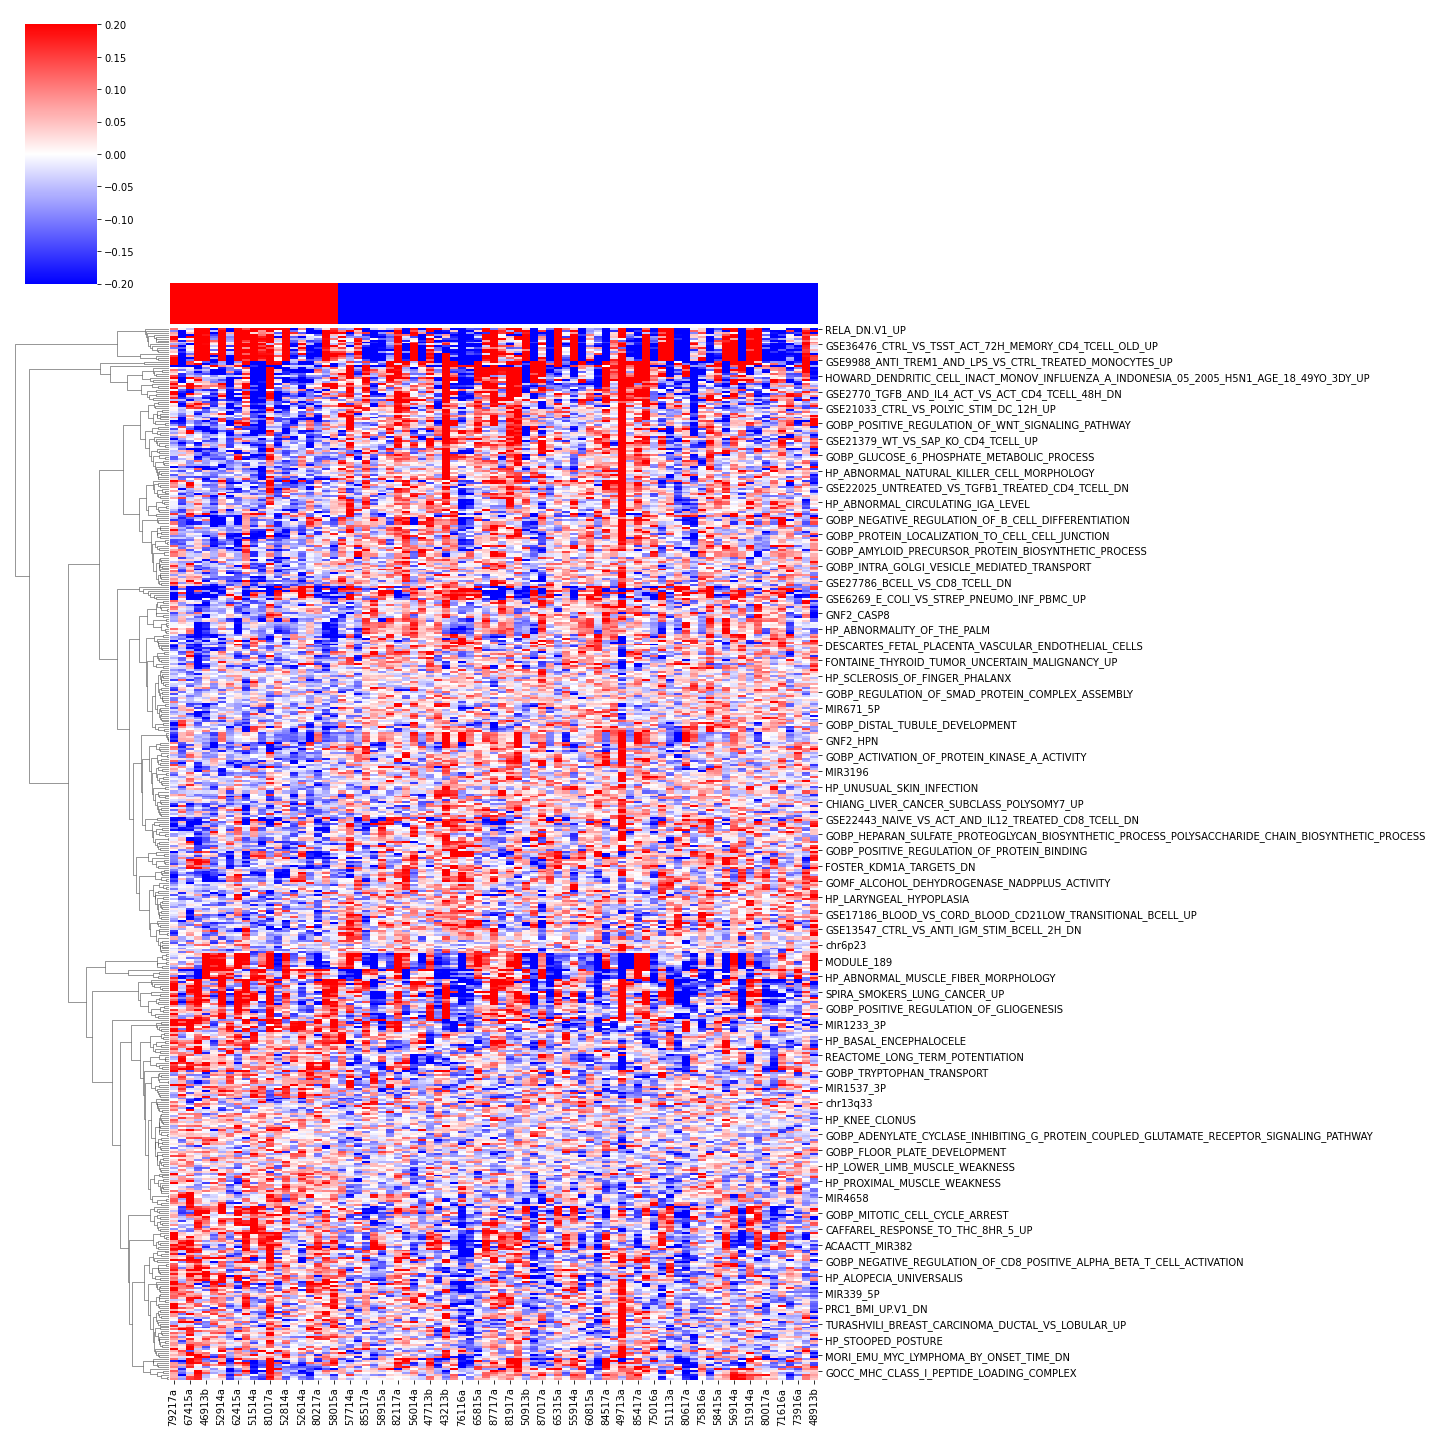

In [8]:
## With healthy
df_long_centered = df_long.subtract(df_long.median(axis=1), axis=0)
#df_long_centered = df_long.loc[intersected_act]
#df_long_centered = df_long_centered.subtract(df_long_centered.median(axis=1), axis=0)

meta_data = pd.read_csv('../data/annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')
longDD_samples, shortDD_samples = _LoadDiseaseDuration(df_long, meta_data, 'long')
df_long_centered = df_long_centered[shortDD_samples+longDD_samples]

lut = dict(zip(['short', 'long'], "rb"))
cate_map = ['short']*len(shortDD_samples)+['long']*len(longDD_samples)
cate_map = [lut[x] for x in cate_map]

lut_d = dict(zip(['RR', 'PP', 'SP', 'RIS', 'CIS', 'Unknown', 'Healthy'], ['red', 'blue', 'black', 'green', 'yellow', 'cyan', 'orange']))
dis_course = meta_data.set_index('HCVB_ID')['DiseaseCourse'].loc[df_long_centered.columns.tolist()].values.tolist()
cated_map = [lut_d[x] for x in dis_course]

lut_t = dict(zip(['Treated', 'TreatmentNaive', 'Healthy'], ['red', 'blue', 'yellow']))
treated_status = meta_data.set_index('HCVB_ID')['Last_Known_Treat_Stat'].loc[df_long_centered.columns.tolist()].values.tolist()
catet_map = [lut_t[x] for x in treated_status]

sns.clustermap(df_long_centered[shortDD_samples+longDD_samples],figsize=(20,20), col_cluster=False, col_colors=cate_map, method='ward', metric='euclidean', cmap='bwr', vmin=-.2, vmax=.2)

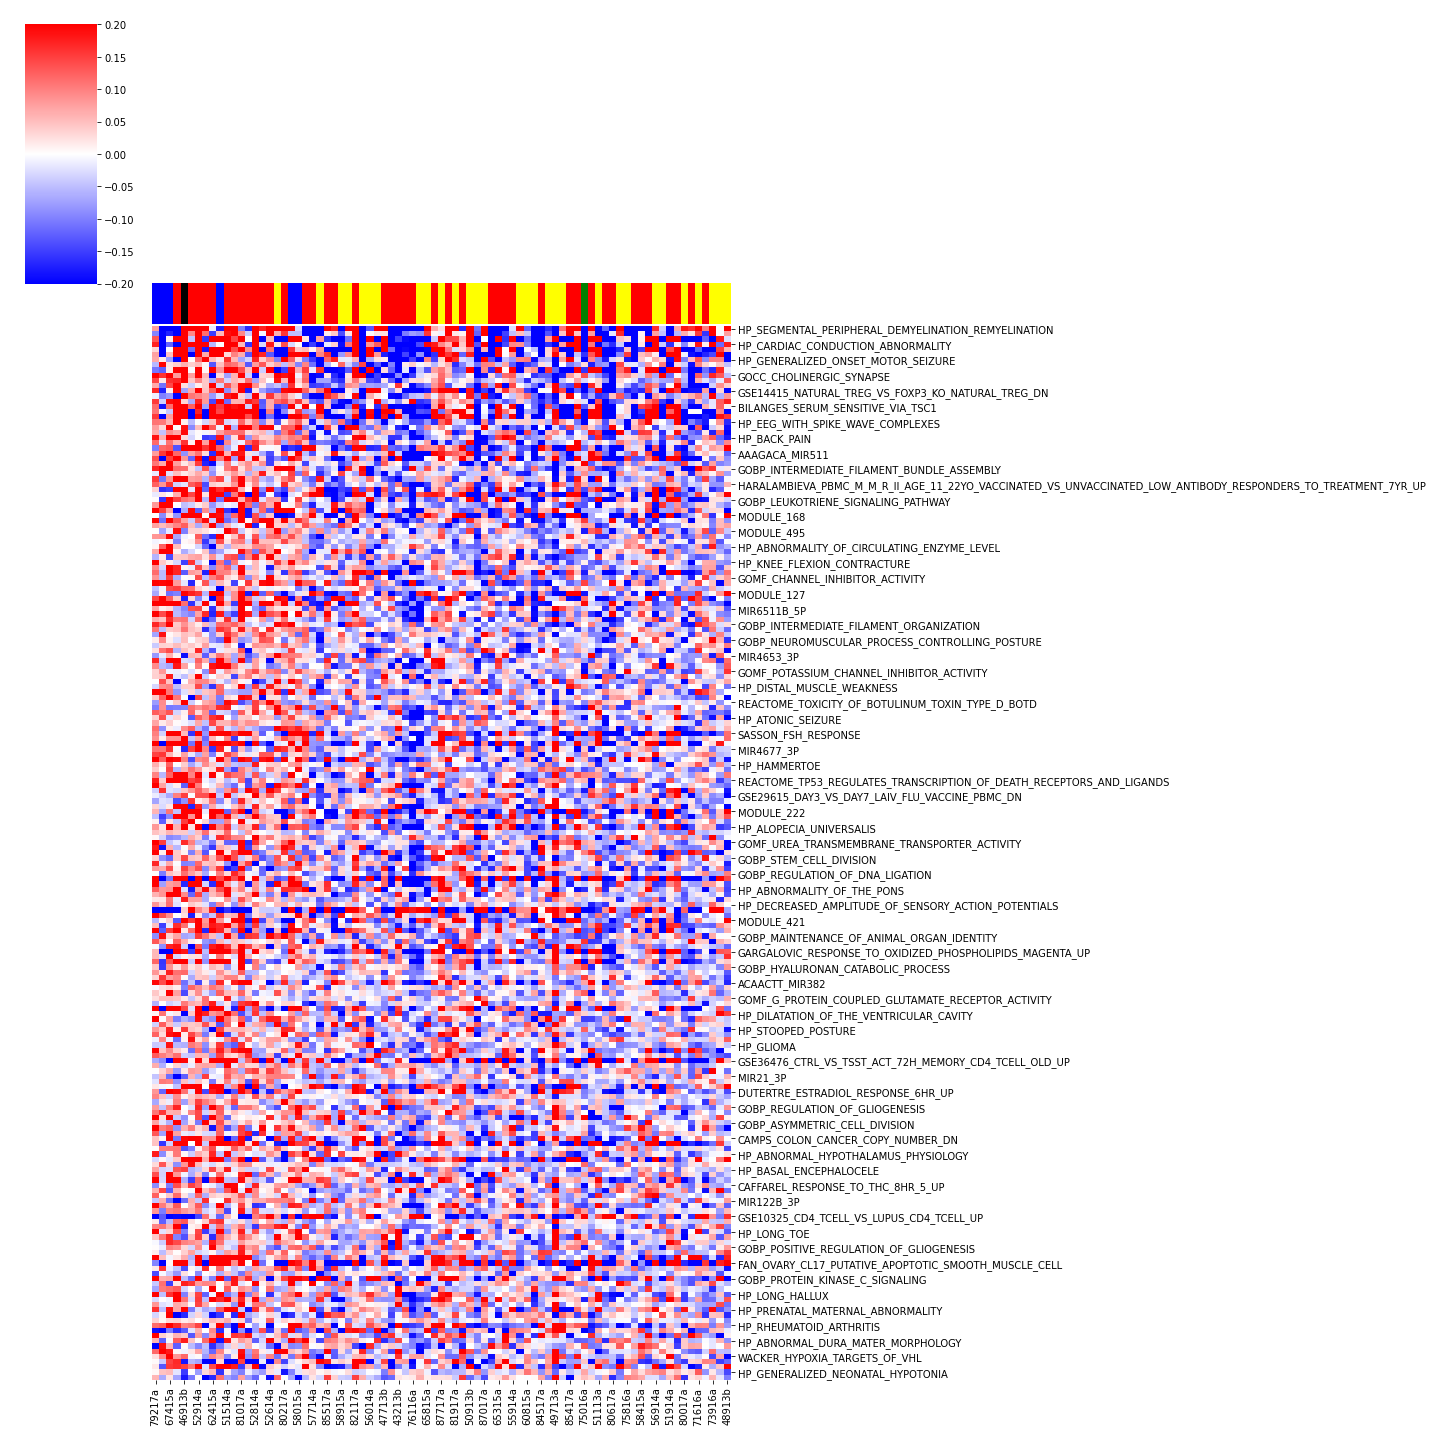

In [5]:
long_mean = df_long_centered[longDD_samples].mean(axis=1).to_frame(name='mean')
long_var = df_long_centered[longDD_samples].var(axis=1).to_frame(name='var')

long_ext = pd.concat([long_mean, long_var], axis=1)
long_neg_act = long_ext.loc[(long_ext['mean']<0)].sort_values(by=['var'],ascending=True)[:400].sort_values(by=['mean'],ascending=True).index.tolist()

sns.clustermap(df_long_centered[shortDD_samples+longDD_samples].loc[long_neg_act],figsize=(20,20),row_cluster=False, col_cluster=False, col_colors=cated_map, method='complete', metric='euclidean', cmap='bwr', vmin=-.2, vmax=.2)

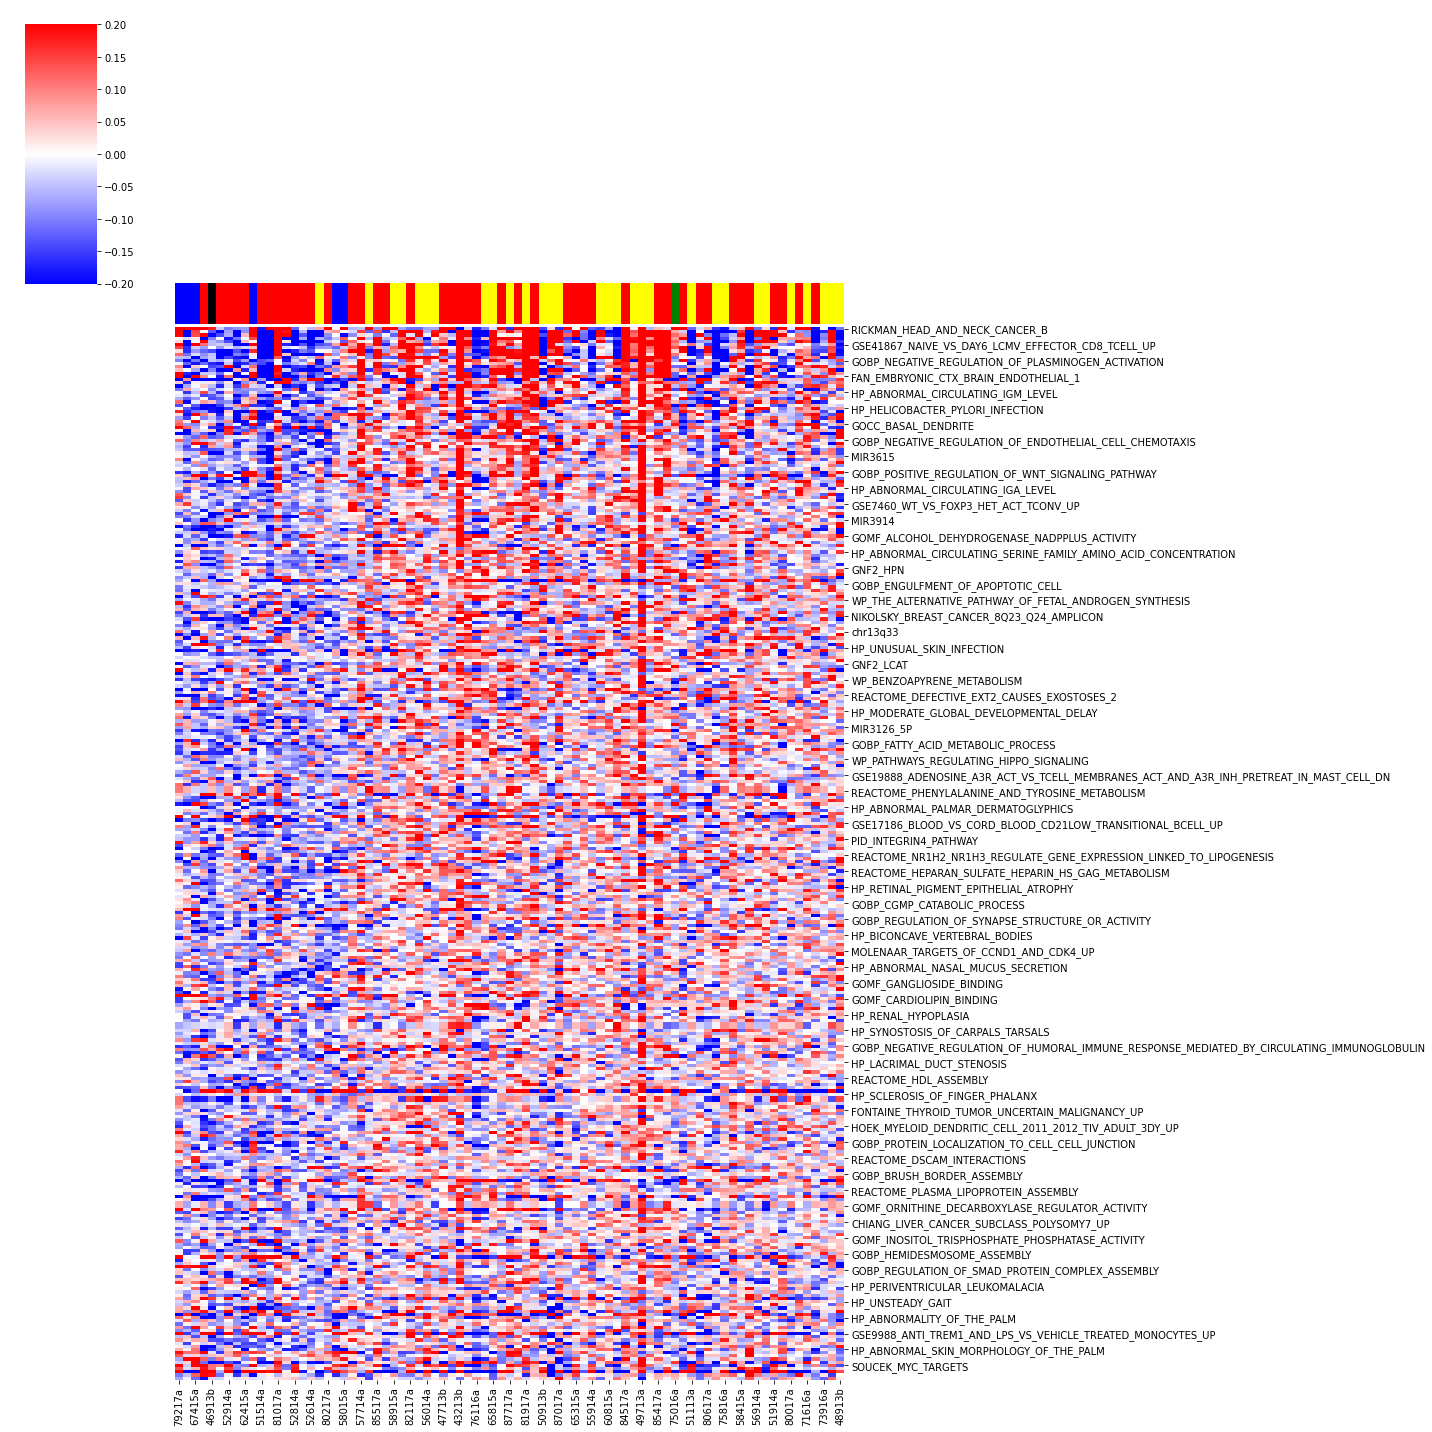

In [6]:
long_pos_act = long_ext.loc[(long_ext['mean']>0)].sort_values(by=['var'],ascending=True)[:500].sort_values(by=['mean'],ascending=False).index.tolist()
sns.clustermap(df_long_centered[shortDD_samples+longDD_samples].loc[long_pos_act],figsize=(20,20),row_cluster=False, col_cluster=False, col_colors=cated_map, method='complete', metric='euclidean', cmap='bwr', vmin=-.2, vmax=.2)